In [1]:
# add additional processes to serve as workers 
n_procs = 15
addprocs(n_procs);  

In [2]:
# add present working directory to path from which to load modules
push!(LOAD_PATH, ".") 

# load module DynamicProgramming on each of the processes 
using DynamicProgrammingReduced
using Interpolations
for p in workers()
    remotecall_fetch(p, eval, :(using DynamicProgrammingReduced))
    remotecall_fetch(p, eval, :(using Interpolations))
end

In [3]:
# nominal parameter value 
@everywhere T1 = 0.680 # seconds in white matter 
@everywhere T2 = 0.090 # seconds in white matter 
@everywhere dT = 0.2   # seconds between acquisitions 
@everywhere sigma = 0.1  # noise strength 
@everywhere theta0 = [exp(-dT/T1); exp(-dT/T2)]

# time horizon 
@everywhere N = 30

# state dimension 
@everywhere n = 6

# initial state
@everywhere x0 = [0.; 0.; 1.; 0; 0; 0]

# define rotation matrices 
@everywhere function Rx(delta::Float64)
    return [1     0           0     ;
            0 cos(delta) -sin(delta);
            0 sin(delta)  cos(delta)]
end
@everywhere function Ry(beta::Float64)
    return [cos(beta) 0 -sin(beta);
                0      1      0     ;
            sin(beta) 0  cos(beta)]
end
@everywhere function Rz(alpha::Float64)
    return [cos(alpha) -sin(alpha) 0;
            sin(alpha)  cos(alpha) 0;
                0           0      1]
end

# dynamics 
@everywhere function f(t::Int64, x::Array{Float64, 1}, u::Array{Float64, 1}, theta::Array{Float64, 1})
    x_state = x[1:3]
    x_sensitivity = x[4:6]
    U = Rz(u[1])*Ry(u[2])*Rx(u[3])
    D = [theta[2], theta[2], theta[1]]
    x_state_plus = U*(D.*x_state) + [0; 0; 1-theta[1]]
    x_sensitivity_plus = U*(D.*x_sensitivity) + U*([0; 0; 1].*x_state) + [0; 0; -1]
    return [x_state_plus; x_sensitivity_plus]
end

# test dynamics 
f(1, x0, [0.; 0.; 0.], theta0)

# reward function 
@everywhere function g(x::Array{Float64, 1}, u::Array{Float64, 1}, theta::Array{Float64, 1})
    return x[4]^2 + x[5]^2 
end

# test reward function 
g(x0, [0.; 0.; 0.], theta0)

# define state grid 
@everywhere nx1 = 3 # number of grid points in each dimension  
@everywhere nx2 = 5
@everywhere nx3 = 7
@everywhere nx4 = 7
@everywhere nx5 = 7
@everywhere xgrid = (
                     linspace(0, 1., nx1), 
                     linspace(-1., 1., nx2), 
                     linspace(-5., 5., nx3), 
                     linspace(-5., 5., nx4), 
                     linspace(-5., 5., nx5), 
                    ) 

# define input grid
# make nu's even so that there is a grid knot at zero
@everywhere nu1 = 1
@everywhere nu2 = 16
@everywhere nu3 = 8
@everywhere ugrid = (
                     linspace(0, 0, nu1), 
                     linspace(-pi, pi-2*pi/nu2, nu2), 
                     linspace(0, pi-pi/nu3, nu3)
                    ) 
ugrid

(linspace(0.0,0.0,1),linspace(-3.1415926535897927,2.748893571891069,16),linspace(0.0,2.748893571891069,8))

In [4]:
# compute value function
@time J = dp_loop(f, g, ugrid, xgrid, theta0, N); 

====== Constructing array J ======
J is size (3,5,7,7,7) by 30
====== Array J constructed  ======
Step k = 29
Step k = 28
Step k = 27
Step k = 26
Step k = 25
Step k = 24
Step k = 23
Step k = 22
Step k = 21
Step k = 20
Step k = 19
Step k = 18
Step k = 17
Step k = 16
Step k = 15
Step k = 14
Step k = 13
Step k = 12
Step k = 11
Step k = 10
Step k = 9
Step k = 8
Step k = 7
Step k = 6
Step k = 5
Step k = 4
Step k = 3
Step k = 2
Step k = 1
333.305744 seconds (2.07 M allocations: 106.778 MB, 0.03% gc time)


In [5]:
# define a finer input grid for policy rollout 
@everywhere nu1 = 1
@everywhere nu2 = 32
@everywhere nu3 = 16
@everywhere ugrid = (
                     linspace(0, 0, nu1), 
                     linspace(-pi, pi-2*pi/nu2, nu2), 
                     linspace(0, pi-pi/nu3, nu3)
                    ) 


# compute optimal trajectory from initial condition x0 
x0 = [0.; 0; 1.; 0.; 0.; 0.]
x_opt, u_opt = dp_rollout(J, x0, f, g, ugrid, xgrid, theta0, N);

In [6]:
using Gadfly
using Colors 

berkeley_blue = RGB((1/256*[ 45.,  99., 127.])...)
berkeley_gold = RGB((1/256*[224., 158.,  25.])...); 
gray          = RGB((1/256*[200., 200., 200.])...); 

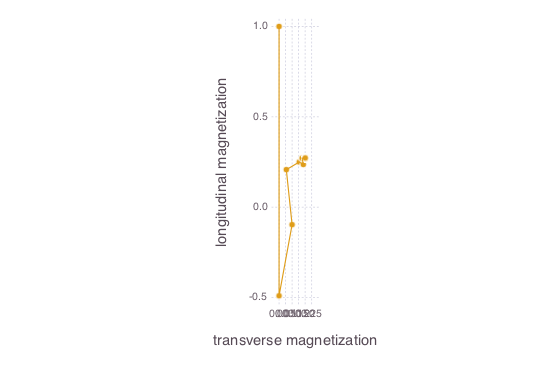

In [7]:
# plot optimal trajectory in transverse vs. longitudinal

p = plot(x=sqrt(x_opt[1, :].^2 + x_opt[2, :].^2), y=x_opt[3, :], 
        Guide.XLabel("transverse magnetization"), 
        Guide.YLabel("longitudinal magnetization"), 
        Geom.path, Geom.point, Coord.cartesian(fixed=true),
        Theme(default_color=berkeley_gold)
)
draw(SVG("MRI_trajectory_transverse_vs_longitudinal.svg", 10cm, 20cm), p)
p

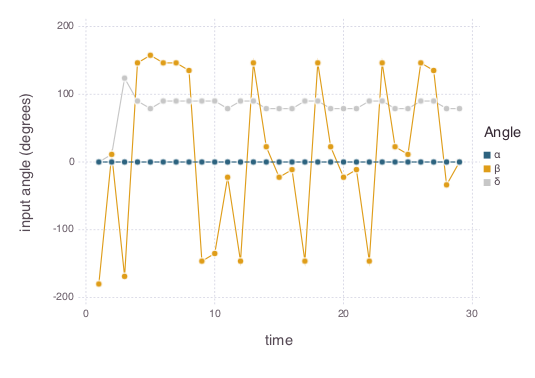

In [8]:
# plot optimal input 

p = plot(layer(x=1:N-1, y=180/pi*u_opt[1, :], Geom.point, Geom.line, Theme(default_color=berkeley_blue)), 
        layer(x=1:N-1, y=180/pi*u_opt[2, :], Geom.point, Geom.line, Theme(default_color=berkeley_gold)), 
        layer(x=1:N-1, y=180/pi*u_opt[3, :], Geom.point, Geom.line, Theme(default_color=gray)), 
        Guide.XLabel("time"), 
        Guide.YLabel("input angle (degrees)"),
Guide.manual_color_key("Angle", ["α", "β", "δ"], [berkeley_blue, berkeley_gold, gray])
)
draw(SVG("MRI_input.svg", 15cm, 10cm), p)
p